In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import re
import requests
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV


In [2]:
with open('coffee_words.pickle','rb') as read_file:
    coffee = pickle.load(read_file)
with open('coffee_ratings.pickle','rb') as read_file:
    ratings = pickle.load(read_file)
with open('combined.pickle','rb') as read_file:
    combined = pickle.load(read_file)
with open('df_full.pickle','rb') as read_file:
    df = pickle.load(read_file)
with open('df_topic_breakdown.pickle','rb') as read_file:
    df_topic_breakdown = pickle.load(read_file)
with open('sentiment.pickle','rb') as read_file:
    sentiment = pickle.load(read_file)

with open('blindtfidf_vec.pickle', 'rb') as read_file:
    blindtfidf = pickle.load(read_file)
with open('blindtfidf_mat.pickle', 'rb') as read_file:
    tfidf_blind = pickle.load(read_file)

In [17]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

## Predicting Rating based on topic assignment

In [3]:
df_topic_breakdown = pd.concat([df_topic_breakdown,sentiment.drop(columns=['roaster','review'])],axis=1)

In [4]:
df_topic_breakdown.columns

Index(['roaster', 'origin', 'roast_level', 'rating', 'length', 'word count',
       'group', 'bright_floral_citrus', 'choc_woody_dark', 'tart_sweet_smooth',
       'cacao_nut_clean', 'sweet_nut_pine', 'juicy_cacao_honey', 'red_berries',
       'woody_nut_caramel', 'cherry_vinuous_choc', 'pos', 'neg', 'compound'],
      dtype='object')

In [372]:
df_topic_breakdown.to_csv(path_or_buf=r'C:\Users\ejfel\Documents\metis_repos\Coffee-Reviews-NLP\coffee')

## RFR on subscores to predict score

In [5]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
features = ['aroma','body','flavor','aftertaste','acidity']
useful = combined[(combined.rating>0)&(combined.aroma>0)&(combined.body>0)&(combined.flavor>0)&(combined.aftertaste>0)&(combined.acidity>0)]
numerical_X, X_numerical, numerical_y, y_numerical = train_test_split(useful[features],useful.rating,test_size=.2,random_state=42)

In [9]:
rf_numerical = RandomForestRegressor(max_depth=10, n_estimators=500,criterion='mse', random_state=0)
rf_numerical.fit(numerical_X, numerical_y)
print(rf_numerical.score(numerical_X, numerical_y))
print(rf_numerical.score(X_numerical, y_numerical))

0.9561816365496244
0.9411986097602637


In [351]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_randomnum = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_randomnum.fit(numerical_X, numerical_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [352]:
rf_randomnum.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [354]:
print(rf_randomnum.score(numerical_X, numerical_y))
print(rf_randomnum.score(X_numerical, y_numerical))

0.9517195717206176
0.9404697902989432


## RFR on reviews to predict score

In [11]:
for_model = df_topic_breakdown[df_topic_breakdown.rating != 'NR']
for_model.rating = for_model.rating.astype(int)

topic_features = ['pos','neg','compound','length','word count','bright_floral_citrus', 'choc_woody_dark', 'tart_sweet_smooth','cacao_nut_clean', 'sweet_nut_pine', 'juicy_cacao_honey', 'red_berries','woody_nut_caramel', 'cherry_vinuous_choc']
big_X, X_big, big_y, y_big = train_test_split(for_model[topic_features],for_model.rating,test_size=.2,random_state=42)

C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
rfr = RandomForestRegressor(max_depth=10, criterion='mae', random_state=0)
rfr.fit(big_X, big_y)

RandomForestRegressor(criterion='mae', max_depth=10, random_state=0)

In [13]:
rfr.score(big_X,big_y)

0.6788130666325242

In [15]:
rfr.score(X_big,y_big)

0.6786098356865988

In [18]:
mae(y_big, rfr.predict(X_big))

1.7406339210747277

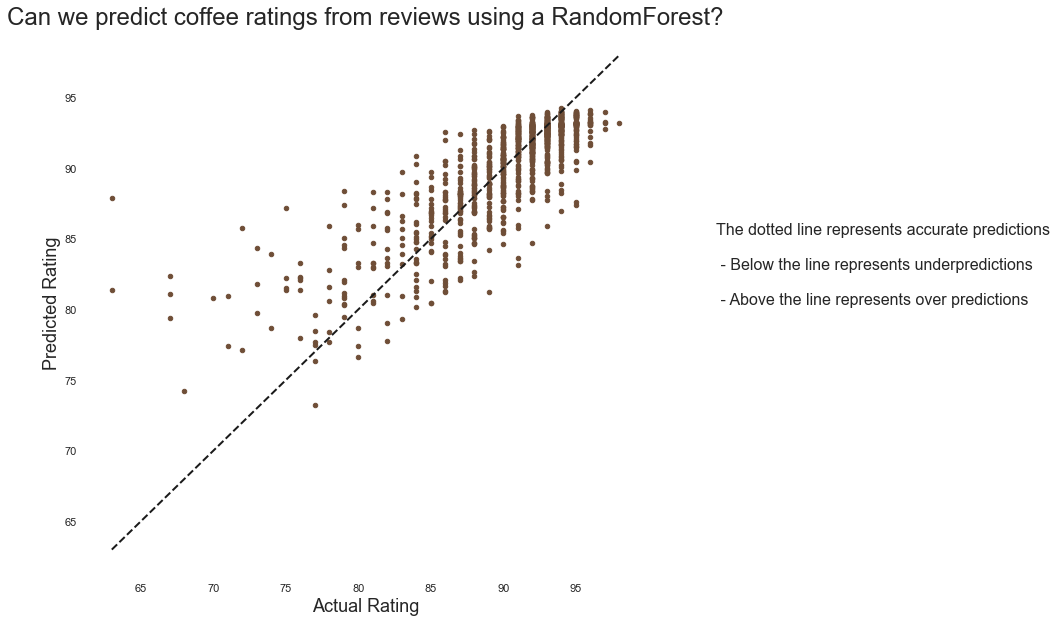

In [16]:
y = useful.rating
test_set_pred = rfr.predict(X_big)
sns.set(rc={'figure.figsize':(10, 10)})
fig, ax = plt.subplots()
ax.scatter(y_big, test_set_pred, s=20,color='#6f4e37')
ax.set_facecolor('white')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Actual Rating',fontsize=18)
ax.set_ylabel('Predicted Rating',fontsize=18)
ax.set_title('Can we predict coffee ratings from reviews using a RandomForest?',fontsize=24)
txt = 'The dotted line represents accurate predictions' + '\n \n'+' - Below the line represents underpredictions' + '\n\n'+ ' - Above the line represents over predictions'
text = fig.text(1,.5,txt,fontsize=16)
plt.savefig(r'C:\Users\ejfel\Documents\metis_repos\Coffee-Reviews-NLP\rfr_word_to_num')
plt.show()

### Considering largest errors in predictions

In [26]:
errors_rf = pd.concat([pd.DataFrame(y_big),pd.DataFrame(X_big)],axis=1)
errors_rf['preds'] = rfr.predict(errors_rf[topic_features])
errors_rf['error'] = np.absolute(errors_rf.rating-errors_rf.preds)
errors_rf.sort_values(by='error',ascending=False).head(10)

,rating,pos,neg,compound,length,word count,bright_floral_citrus,choc_woody_dark,tart_sweet_smooth,cacao_nut_clean,sweet_nut_pine,juicy_cacao_honey,red_berries,woody_nut_caramel,cherry_vinuous_choc,preds,error
3532,63,0.145,0.056,0.5719,240,21,0.006650,0.000000,0.000000,0.000000,0.015168,0.002739,0.002741,0.020428,0.026225,87.925,24.925
5830,63,0.131,0.076,0.9135,1172,50,0.002594,0.000000,0.000000,0.000000,0.000000,0.000444,0.000000,0.019024,0.033497,81.400,18.400
3534,67,0.033,0.043,-0.1027,273,22,0.000060,0.021956,0.000000,0.000000,0.004294,0.000800,0.000962,0.025729,0.004686,82.350,15.350
5523,67,0.225,0.216,0.3919,340,22,0.007297,0.000000,0.000000,0.000000,0.001432,0.002460,0.000000,0.025901,0.000000,81.095,14.095
978,72,0.081,0.039,0.4588,416,34,0.000000,0.038827,0.000965,0.019040,0.014875,0.000000,0.000000,0.058978,0.000000,85.810,13.810
3007,67,0.161,0.128,0.2718,318,24,0.000850,0.000235,0.000000,0.000000,0.000000,0.000000,0.000000,0.049224,0.000000,79.430,12.430
5465,75,0.185,0.055,0.8176,314,25,0.008200,0.006497,0.002462,0.000000,0.000000,0.004334,0.006068,0.033863,0.005032,87.215,12.215
3303,73,0.088,0.029,0.5454,350,21,0.008889,0.000000,0.000000,0.000506,0.000000,0.015240,0.000000,0.047644,0.004958,84.380,11.380
5920,70,0.119,0.164,-0.2152,221,16,0.004589,0.000861,0.000000,0.008898,0.000945,0.000000,0.000000,0.047132,0.008463,80.795,10.795
5918,71,0.100,0.044,0.4872,208,12,0.000000,0.001505,0.000367,0.000000,0.000000,0.000469,0.003358,0.047818,0.000736,80.940,9.940


In [32]:
coffee.iloc[3007].Review

'Flat and woody with a cloying, disturbing sweetness and not much else in way of flavor or aroma. The sweetness could be taken as slightly composty or slightly chocolaty or both. Virtually no acidity; smooth but leanish mouthfeel. The composty sweetness is most intense and unpleasant in the cup, less so in the finish.'

## GridSearch/RandomizedSearch CV for hyperparameters on RF

In [336]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(big_X, big_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [337]:
print(rf_random.score(big_X,big_y))
print(rf_random.score(X_big,y_big))

0.9919291285935002
0.6907053376038641


In [338]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(big_X, big_y)
base_accuracy = evaluate(base_model, X_big, y_big)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_big, y_big)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 1.8460 degrees.
Accuracy = 97.87%.
Model Performance
Average Error: 1.6863 degrees.
Accuracy = 98.05%.
Improvement of 0.18%.


In [339]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',
                      min_samples_split=5, n_estimators=600)

In [341]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 5, 10, 60, 100],
#     'max_features': ,
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [4,5,6],
    'n_estimators': [100, 300, 600, 750]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [342]:
# Fit the grid search to the data
grid_search.fit(big_X, big_y)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_big, y_big)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 13.0min finished


Model Performance
Average Error: 1.7197 degrees.
Accuracy = 98.02%.
Improvement of 0.15%.


In [343]:
best_grid


RandomForestRegressor(max_depth=60, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=600)

In [344]:
print(best_grid.score(big_X,big_y))
print(best_grid.score(X_big,y_big))

0.9359872889461786
0.6811182793639442


In [356]:
with open('words_to_score_rf.pickle', 'wb') as to_write:
    pickle.dump(best_grid, to_write)

## Different Versions of Linear Models on Predicting Scores

Initial model on NMF assignments across 2-10 topics got r^2 of .26 and average error of 2.7 on score  
Second model using NMF vectors for each review got r^2 of .50 and average error of 2.2 on score  
Third model included review length and count vector sum got r^2 of .53 and average error of 2.1 on score  
Fourth model including sentiment analysis (pos, neg, compound scores) got r^2 of .59 and average error of 1.99  

This points me to believe that the average review may only account for a portion of the final review score

In [326]:
topic_features = ['pos','neg','compound','length','word count','bright_floral_citrus', 'choc_woody_dark', 'tart_sweet_smooth','cacao_nut_clean', 'sweet_nut_pine', 'juicy_cacao_honey', 'red_berries','woody_nut_caramel', 'cherry_vinuous_choc']
np.linspace(start = 50, stop = 500, num = 10)

array([ 50., 100., 150., 200., 250., 300., 350., 400., 450., 500.])

In [282]:
for_model = df_topic_breakdown[df_topic_breakdown.rating != 'NR']
for_model.rating = for_model.rating.astype(int)
big_X, X_big, big_y, y_big = train_test_split(for_model[topic_features],for_model.rating,test_size=.2,random_state=42)

C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [283]:
train_X, train_y = np.array(big_X), np.array(big_y)
#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(tr_X, tr_y)
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

test_set_pred = lm.predict(X_big)

mae_kfoldlinear = mae(y_big,test_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldlinear)

Simple regression scores:  [0.597, 0.61, 0.601, 0.587, 0.562] 

Simple mean cv r^2: 0.591 +- 0.016 

The average error (MAE) on a predicted value on the holdout test data is:  1.9978003029904747


In [284]:
list(zip(big_X.columns, lm.coef_))

[('pos', -2.6155616671168005),
 ('neg', -37.135879833679795),
 ('compound', 2.493541146002903),
 ('length', -0.012562114260267609),
 ('word count', 0.23403649213257308),
 ('bright_floral_citrus', 57.215110563435225),
 ('choc_woody_dark', 17.725129099693856),
 ('tart_sweet_smooth', 30.9375353650145),
 ('cacao_nut_clean', 8.205166997187849),
 ('sweet_nut_pine', -0.369238129503529),
 ('juicy_cacao_honey', 12.686145317773786),
 ('red_berries', 21.468285848846357),
 ('woody_nut_caramel', -31.1228876889177),
 ('cherry_vinuous_choc', 23.392100649405275)]

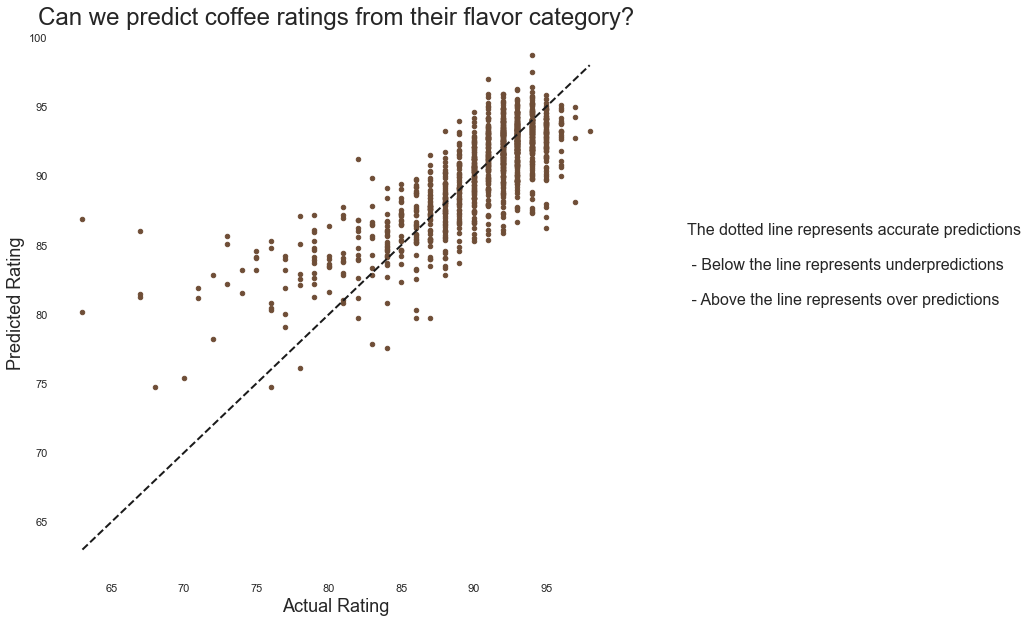

In [285]:
y = useful.rating
sns.set(rc={'figure.figsize':(10, 10)})
fig, ax = plt.subplots()
ax.scatter(y_big, test_set_pred, s=20,color='#6f4e37')
ax.set_facecolor('white')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Actual Rating',fontsize=18)
ax.set_ylabel('Predicted Rating',fontsize=18)
ax.set_title('Can we predict coffee ratings from their flavor category?',fontsize=24)
txt = 'The dotted line represents accurate predictions' + '\n \n'+' - Below the line represents underpredictions' + '\n\n'+ ' - Above the line represents over predictions'
text = fig.text(1,.5,txt,fontsize=16)
# fig.savefig('OneDrive\Desktop\Metis\Projects\Project 2\wridge_actualvspredicted',kind='png')
plt.show()

In [222]:
error_on_words = pd.concat([pd.DataFrame(y_big),pd.DataFrame(X_big)],axis=1)
error_on_words['preds'] = lm.predict(error_on_words[topic_features])
error_on_words['error'] = np.absolute(error_on_words.rating-error_on_words.preds)
error_on_words.sort_values(by='error',ascending=False).head(3)

,rating,pos,neg,compound,length,word count,bright_floral_citrus,choc_woody_dark,tart_sweet_smooth,cacao_nut_clean,sweet_nut_pine,juicy_cacao_honey,red_berries,woody_nut_caramel,cherry_vinuous_choc,preds,error
3532,63,0.123,0.030,0.8070,240,21,0.006650,0.000000,0.0,0.0,0.015168,0.002739,0.002741,0.020428,0.026225,86.873642,23.873642
3534,67,0.077,0.022,0.6694,273,22,0.000060,0.021956,0.0,0.0,0.004294,0.000800,0.000962,0.025729,0.004686,86.051939,19.051939
5830,63,0.119,0.082,0.8896,1172,50,0.002594,0.000000,0.0,0.0,0.000000,0.000444,0.000000,0.019024,0.033497,80.137572,17.137572


In [357]:
with open('words_to_score_linear.pickle', 'wb') as to_write:
    pickle.dump(lm, to_write)

## Predicting subcategories

In [227]:
subcats = pd.concat([for_model,combined.drop(columns=['roaster','origin','roast_level','group'])],axis=1)
subcats.columns

Index(['roaster', 'origin', 'roast_level', 'rating', 'length', 'word count',
       'group', 'bright_floral_citrus', 'choc_woody_dark', 'tart_sweet_smooth',
       'cacao_nut_clean', 'sweet_nut_pine', 'juicy_cacao_honey', 'red_berries',
       'woody_nut_caramel', 'cherry_vinuous_choc', 'pos', 'neg', 'compound',
       'rating', 'aroma', 'body', 'flavor', 'aftertaste', 'acidity'],
      dtype='object')

In [286]:
modeling_aroma = subcats[(subcats.roaster.isnull() == False)&(subcats.aroma.isnull() == False)&(subcats.aroma>0)]
modeling_aroma.aroma = modeling_aroma.aroma.astype(int)

aroma_X, X_aroma, aroma_y, y_aroma = train_test_split(modeling_aroma[topic_features],modeling_aroma.aroma,test_size=.2,random_state=42)
train_X, train_y = np.array(aroma_X), np.array(aroma_y)

#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lm_aroma = LinearRegression()

    lm_aroma.fit(tr_X, tr_y)
    cv_lm_r2s.append(round(lm_aroma.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

test_set_pred = lm_aroma.predict(X_aroma)

mae_kfoldlinear = mae(y_aroma,test_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldlinear)

Simple regression scores:  [0.486, 0.379, 0.496, 0.479, 0.494] 

Simple mean cv r^2: 0.467 +- 0.044 

The average error (MAE) on a predicted value on the holdout test data is:  0.5140084958599477


C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [287]:
modeling_body = subcats[(subcats.roaster.isnull() == False)&(subcats.body.isnull() == False)&(subcats.body>0)]
modeling_body.body = modeling_body.body.astype(int)

body_X, X_body, body_y, y_body = train_test_split(modeling_body[topic_features],modeling_body.body,test_size=.2,random_state=42)
train_X, train_y = np.array(body_X), np.array(body_y)

#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lm_body = LinearRegression()

    lm_body.fit(tr_X, tr_y)
    cv_lm_r2s.append(round(lm_body.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

test_set_pred = lm_body.predict(X_body)

mae_kfoldlinear = mae(y_body,test_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldlinear)

Simple regression scores:  [0.443, 0.432, 0.469, 0.422, 0.425] 

Simple mean cv r^2: 0.438 +- 0.017 

The average error (MAE) on a predicted value on the holdout test data is:  0.5264061628369012


C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [288]:
modeling_flavor = subcats[(subcats.roaster.isnull() == False)&(subcats.flavor.isnull() == False)&(subcats.flavor>0)]
modeling_flavor.flavor = modeling_flavor.flavor.astype(int)

flavor_X, X_flavor, flavor_y, y_flavor = train_test_split(modeling_flavor[topic_features],modeling_flavor.flavor,test_size=.2,random_state=42)
train_X, train_y = np.array(flavor_X), np.array(flavor_y)

#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lm_flavor = LinearRegression()

    lm_flavor.fit(tr_X, tr_y)
    cv_lm_r2s.append(round(lm_flavor.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

test_set_pred = lm_flavor.predict(X_flavor)

mae_kfoldlinear = mae(y_flavor,test_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldlinear)

Simple regression scores:  [0.576, 0.55, 0.557, 0.502, 0.579] 

Simple mean cv r^2: 0.553 +- 0.028 

The average error (MAE) on a predicted value on the holdout test data is:  0.4942264744623297


C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [289]:
modeling_aftertaste = subcats[(subcats.roaster.isnull() == False)&(subcats.aftertaste.isnull() == False)&(subcats.aftertaste>0)]
modeling_aftertaste.aftertaste = modeling_aftertaste.aftertaste.astype(int)

aftertaste_X, X_aftertaste, aftertaste_y, y_aftertaste = train_test_split(modeling_aftertaste[topic_features],modeling_aftertaste.aftertaste,test_size=.2,random_state=42)
train_X, train_y = np.array(aftertaste_X), np.array(aftertaste_y)

#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lm_aftertaste = LinearRegression()

    lm_aftertaste.fit(tr_X, tr_y)
    cv_lm_r2s.append(round(lm_aftertaste.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

test_set_pred = lm_aftertaste.predict(X_aftertaste)

mae_kfoldlinear = mae(y_aftertaste,test_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldlinear)

Simple regression scores:  [0.19, 0.167, 0.257, 0.248, 0.26] 

Simple mean cv r^2: 0.224 +- 0.038 

The average error (MAE) on a predicted value on the holdout test data is:  0.4745089857737524


C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [290]:
modeling_acidity = subcats[(subcats.roaster.isnull() == False)&(subcats.acidity.isnull() == False)&(subcats.acidity>0)]
modeling_acidity.acidity = modeling_acidity.acidity.astype(int)

acidity_X, X_acidity, acidity_y, y_acidity = train_test_split(modeling_acidity[topic_features],modeling_acidity.acidity,test_size=.2,random_state=42)
train_X, train_y = np.array(acidity_X), np.array(acidity_y)

#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lm_acidity = LinearRegression()

    lm_acidity.fit(tr_X, tr_y)
    cv_lm_r2s.append(round(lm_acidity.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

test_set_pred = lm_acidity.predict(X_acidity)

mae_kfoldlinear = mae(y_acidity,test_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldlinear)

Simple regression scores:  [0.547, 0.583, 0.577, 0.513, 0.499] 

Simple mean cv r^2: 0.544 +- 0.033 

The average error (MAE) on a predicted value on the holdout test data is:  0.5706627887226385


C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Use the above models to make predictions for scores, then combining for a prediction on final score

In [291]:
subcat_preds = pd.DataFrame()
subcat_preds['pred_aroma'] = lm_aroma.predict(big_X[topic_features])
subcat_preds['pred_body'] = lm_body.predict(big_X[topic_features])
subcat_preds['pred_aftertaste'] = lm_aftertaste.predict(big_X[topic_features])
subcat_preds['pred_flavor'] = lm_flavor.predict(big_X[topic_features])
subcat_preds['pred_acidity'] = lm_acidity.predict(big_X[topic_features])
subcat_preds['rating'] = big_y
subcat_preds.head(4)

,pred_aroma,pred_body,pred_aftertaste,pred_flavor,pred_acidity,rating
0,8.485640,8.114167,8.313316,8.582578,8.198264,93.0
1,9.583666,8.963000,8.670203,10.187582,9.671808,92.0
2,9.096377,8.783150,8.125554,9.230827,8.717394,96.0
3,6.974857,6.779329,7.471054,6.843888,6.318828,95.0


In [292]:
subcat_preds.describe()

,pred_aroma,pred_body,pred_aftertaste,pred_flavor,pred_acidity,rating
count,4763.000000,4763.000000,4763.000000,4763.000000,4763.000000,3807.000000
mean,8.237124,7.944908,7.858724,8.317786,7.730276,91.652220
std,0.678111,0.603435,0.404017,0.806189,0.847041,2.908643
min,5.233174,5.524063,5.982486,4.844183,4.003198,52.000000
25%,7.805281,7.539129,7.610268,7.786997,7.157785,90.000000
50%,8.377643,8.057208,7.936921,8.515331,7.901968,92.000000
75%,8.750958,8.411347,8.148504,8.924902,8.363624,93.000000
max,9.692005,9.250000,8.846855,10.187582,9.671808,98.000000


In [273]:
combined[(combined.rating>0)&(combined.aroma>0)&(combined.body>0)&(combined.flavor>0)&(combined.aftertaste>0)&(combined.acidity>0)].drop(columns=['group','rating']).describe()

,aroma,body,flavor,aftertaste,acidity
count,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000
mean,8.497194,8.210783,8.639424,7.958283,8.091486
std,0.750584,0.661624,0.780289,0.737986,0.799691
min,2.000000,5.000000,1.000000,2.000000,1.000000
25%,8.000000,8.000000,8.000000,8.000000,8.000000
50%,9.000000,8.000000,9.000000,8.000000,8.000000
75%,9.000000,9.000000,9.000000,8.000000,9.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000


In [293]:
features = ['pred_aroma','pred_body','pred_flavor','pred_aftertaste','pred_acidity']
to_model = subcat_preds[subcat_preds.rating.isnull()==False]

sub_X, X_sub, sub_y, y_sub = train_test_split(to_model[features],to_model.rating,test_size=.2,random_state=42)
train_X, train_y = np.array(sub_X), np.array(sub_y)
#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lm_subcats = LinearRegression()

    lm_subcats.fit(tr_X, tr_y)
    cv_lm_r2s.append(round(lm_subcats.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

test_set_pred = lm_subcats.predict(X_sub)

mae_kfoldlinear = mae(y_sub,test_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldlinear)

Simple regression scores:  [-0.005, -0.019, -0.01, -0.005, -0.003] 

Simple mean cv r^2: -0.008 +- 0.006 

The average error (MAE) on a predicted value on the holdout test data is:  2.0495132822338915


In [304]:
print('The strong model predicting on predicted subcats has a r^2 score of: ',lm_scores.score(X_, y_))

test_set_pred = lm_numerical.predict(X_sub)
mae_kfoldlinear = mae(y_sub,test_set_pred)
print('The average error (MAE) on a predicted value predicted from subcats test data is: ',mae_kfoldlinear)

The strong model predicting on predicted subcats has a r^2 score of:  -1.2314740909332493
The average error (MAE) on a predicted value predicted from subcats test data is:  3.383374901653508


## Straight up numerical reviews to predict overall score

In [210]:
combined.head(1)

,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
0,Jackrabbit Java,Costa Rica,Medium-Light,1,93,9.0,9.0,9.0,8.0,8.0


In [224]:
combined.loc[(combined.aroma == 'NR')|(combined.aroma == 'NA'),'aroma'] = '-999'
combined.aroma = combined.aroma.astype(float)
combined.aroma = combined.aroma.round(0)

combined.loc[(combined.body == 'NR')|(combined.body == 'NA'),'body'] = '-999'
combined.body = combined.body.astype(float)
combined.body = combined.body.round(0)

combined.loc[(combined.flavor == 'NR')|(combined.flavor == 'NA'),'flavor'] = '-999'
combined.flavor = combined.flavor.astype(float)
combined.flavor = combined.flavor.round(0)

combined.aftertaste.fillna('-999',inplace=True)
combined.aftertaste = combined.aftertaste.astype(float)
combined.aftertaste = combined.aftertaste.round(0)

combined.loc[(combined.acidity == 'NR')|(combined.acidity == 'NA')|(combined.acidity == 'na')|(combined.acidity == 'n/a'),'acidity'] = '-999'
combined.loc[(combined.acidity == 'Very Low'),'acidity'] = '1'
combined.loc[(combined.acidity == 'Low'),'acidity'] = '3'
combined.loc[(combined.acidity == 'Moderate'),'acidity'] = '5'
combined.acidity.fillna(-999,inplace=True)
combined.acidity = combined.acidity.astype(float)
combined.acidity = combined.acidity.round(0)

# combined.dropna(subset=['rating','aroma','body','flavor','aftertaste','acidity'],axis=0,inplace=True)

C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [296]:
features = ['aroma','body','flavor','aftertaste','acidity']
useful = combined[(combined.rating>0)&(combined.aroma>0)&(combined.body>0)&(combined.flavor>0)&(combined.aftertaste>0)&(combined.acidity>0)]
numerical_X, X_numerical, numerical_y, y_numerical = train_test_split(useful[features],useful.rating,test_size=.2,random_state=42)

In [275]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [19]:
train_X, train_y = np.array(numerical_X), np.array(numerical_y)
#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lm_numerical = LinearRegression()

    lm_numerical.fit(tr_X, tr_y)
    cv_lm_r2s.append(round(lm_numerical.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

test_set_pred = lm_numerical.predict(X_numerical)

mae_kfoldlinear = mae(y_numerical,test_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldlinear)

Simple regression scores:  [0.942, 0.934, 0.96, 0.944, 0.933] 

Simple mean cv r^2: 0.943 +- 0.010 

The average error (MAE) on a predicted value on the holdout test data is:  0.3614933494948243


In [20]:
list(zip(numerical_X.columns, lm_numerical.coef_))

[('aroma', 1.0418377367675011),
 ('body', 0.7491857751629859),
 ('flavor', 1.003140009198338),
 ('aftertaste', 1.1398576026692442),
 ('acidity', 0.8886668258127939)]

In [24]:
lm_numerical.intercept_

51.659800010176

In [21]:
alphavec = 10**np.linspace(-2,2,200)
std = StandardScaler()
std.fit(numerical_X)
num_X = std.transform(numerical_X)

lasso =  LassoCV(alphas = alphavec, cv = 5)
lasso.fit(num_X,numerical_y)
list(zip(numerical_X.columns, lasso.coef_))

[('aroma', 0.762685361734256),
 ('body', 0.48443267950792995),
 ('flavor', 0.7936152348422367),
 ('aftertaste', 0.8508650016952471),
 ('acidity', 0.7192498495414757)]

In [22]:
test_lasso_pred = lasso.predict(std.transform(X_numerical))
mae_lasso = mae(y_numerical,test_lasso_pred)
print('The r^2 on a predicted value is: ',r2_score(y_numerical, test_lasso_pred))
print('The average error (MAE) on a predicted value is: ',mae_lasso)

The r^2 on a predicted value is:  0.9438300261450571
The average error (MAE) on a predicted value is:  0.3650037421854297


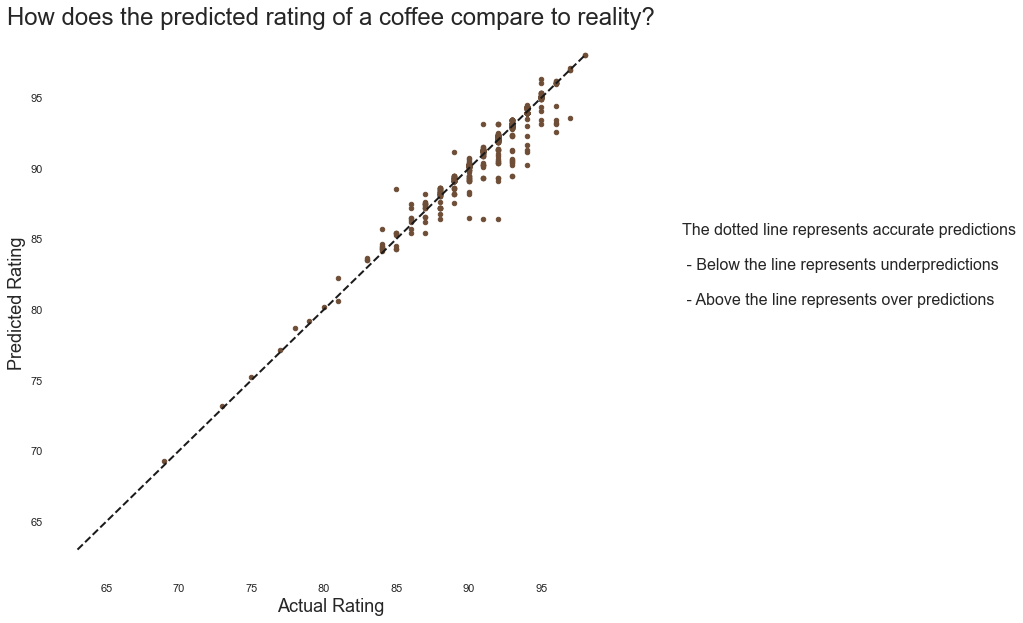

In [23]:
y = useful.rating
sns.set(rc={'figure.figsize':(10, 10)})
fig, ax = plt.subplots()
ax.scatter(y_numerical, test_set_pred, s=20,color='#6f4e37')
ax.set_facecolor('white')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Actual Rating',fontsize=18)
ax.set_ylabel('Predicted Rating',fontsize=18)
ax.set_title('How does the predicted rating of a coffee compare to reality?',fontsize=24)
txt = 'The dotted line represents accurate predictions' + '\n \n'+' - Below the line represents underpredictions' + '\n\n'+ ' - Above the line represents over predictions'
text = fig.text(1,.5,txt,fontsize=16)
plt.savefig(r'C:\Users\ejfel\Documents\metis_repos\Coffee-Reviews-NLP\Visuals\linear_num_to_num')
plt.show()



In [303]:
errors = pd.concat([pd.DataFrame(y_numerical),pd.DataFrame(X_numerical)],axis=1)
errors['preds'] = lm_numerical.predict(errors[features])
errors['error'] = np.absolute(errors.rating-errors.preds)
errors.sort_values(by='error',ascending=False).head(10)

,rating,aroma,body,flavor,aftertaste,acidity,preds,error
4022,92,7.0,7.0,8.0,7.0,7.0,86.421756,5.578244
4929,91,7.0,7.0,8.0,7.0,7.0,86.421756,4.578244
4619,94,8.0,8.0,8.0,8.0,8.0,90.241304,3.758696
4909,90,8.0,7.0,7.0,7.0,7.0,86.460453,3.539547
4393,93,8.0,7.0,8.0,8.0,8.0,89.492118,3.507882
4362,93,8.0,7.0,8.0,8.0,8.0,89.492118,3.507882
4761,85,9.0,7.0,8.0,7.0,7.0,88.505431,3.505431
4496,96,9.0,7.0,10.0,8.0,8.0,92.540236,3.459764
4359,97,10.0,7.0,10.0,8.0,8.0,93.582073,3.417927
4415,92,8.0,8.0,8.0,7.0,8.0,89.101446,2.898554


In [358]:
with open('subcats_to_score_lasso.pickle', 'wb') as to_write:
    pickle.dump(lasso, to_write)

In [98]:
combined.loc[[4022,4929,4619,4909,4393,4496,4761,4362,4359,4415]]

,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
4022,Green Mountain Coffee,South-central Kenya,Medium-Dark,2,92,7.0,7.0,8.0,7.0,7.0
4929,Iron Brew Coffee,"Cerrado growing region, Minas Gerais State, Br...",Medium-Light,1,91,7.0,7.0,8.0,7.0,7.0
4619,Atomic Cafe Coffee Roasters,"Narino Department, southern Colombia",Medium,1,94,8.0,8.0,8.0,8.0,8.0
4909,The Roasterie,Colombia,Medium,1,90,8.0,7.0,7.0,7.0,7.0
4393,Klatch Coffee,"Huila Department, Colombia.",Medium-Light,1,93,8.0,7.0,8.0,8.0,8.0
4496,Paradise Roasters,"Boquete growing region, western Panama",Medium,1,96,9.0,7.0,10.0,8.0,8.0
4761,Supreme Bean Coffee Roasters,"Kaanapali district, near Lahaina, West Maui, H...",Medium-Light,0,85,9.0,7.0,8.0,7.0,7.0
4362,Green Mountain Coffee,"Yirgacheffe growing region, Sidamo Province, s...",Medium,2,93,8.0,7.0,8.0,8.0,8.0
4359,Terroir Coffee,South-central Kenya.,Medium,2,97,10.0,7.0,10.0,8.0,8.0
4415,PT's Coffee Roasting Co.,Rwanda.,Medium,1,92,8.0,8.0,8.0,7.0,8.0


## Model based solely on NMF topics assigned across multiple NMF models from full text

This was not very useful, don't follow up

In [104]:
one_hot = pd.get_dummies(df,columns=['Two Topic','Three Topic','Four Topic','Five Topic','Six Topic','Seven Topic','Eight Topic','Nine Topic','Ten Topic'])
one_hot = one_hot[one_hot.rating>0]

In [126]:
_X, X_, _y, y_ = train_test_split(one_hot.drop(columns=['Roaster','Text','rating']),one_hot.rating,test_size=.2,random_state=42)

In [135]:
train_X, train_y = np.array(_X), np.array(_y)
#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(train_X,train_y):
    
    tr_X, tr_y = train_X[train_ind], train_y[train_ind]
    X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
    #simple linear regression
    lmwords = LinearRegression()

    lmwords.fit(tr_X, tr_y)
    cv_lm_r2s.append(round(lmwords.score(X_val, y_val), 3))

print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}','\n')

word_set_pred = lmwords.predict(X_)

mae_kfoldwords = mae(y_,word_set_pred)

print('The average error (MAE) on a predicted value on the holdout test data is: ',mae_kfoldwords)

alphavec = 10**np.linspace(-2,2,200)
std_words= StandardScaler()
std_words.fit(_X)
X_words = std_words.transform(_X)

lasso_words =  LassoCV(alphas = alphavec, cv = 5)
lasso_words.fit(X_words,_y)
word_lasso_pred = lasso_words.predict(std_words.transform(X_))
list(zip(_X.columns, lasso_words.coef_))


Simple regression scores:  [0.246, 0.265, 0.291, 0.285, 0.253] 

Simple mean cv r^2: 0.268 +- 0.018 

The average error (MAE) on a predicted value on the holdout test data is:  2.719531413990344


[('Two Topic_0', 0.5140477122150904),
 ('Two Topic_1', -0.0),
 ('Three Topic_0', -0.0),
 ('Three Topic_1', 0.0640247909443561),
 ('Three Topic_2', -0.2776935253460187),
 ('Four Topic_0', 0.006912757950952578),
 ('Four Topic_1', -0.06933296799158246),
 ('Four Topic_2', 0.07306618932624573),
 ('Four Topic_3', -0.0),
 ('Five Topic_0', 0.0),
 ('Five Topic_1', -0.46373166369515545),
 ('Five Topic_2', -0.11739952805809296),
 ('Five Topic_3', 0.4411901336077375),
 ('Five Topic_4', 0.0),
 ('Six Topic_0', 0.013581674626825524),
 ('Six Topic_1', -0.0),
 ('Six Topic_2', -0.6722797244927596),
 ('Six Topic_3', 0.09787206150569563),
 ('Six Topic_4', -0.0),
 ('Six Topic_5', -0.0),
 ('Seven Topic_0', -0.15749577369307996),
 ('Seven Topic_1', 0.0),
 ('Seven Topic_2', -0.0),
 ('Seven Topic_3', 0.05898042593706846),
 ('Seven Topic_4', -0.2896866059890552),
 ('Seven Topic_5', -0.14984270668322006),
 ('Seven Topic_6', 0.09544904920202368),
 ('Eight Topic_0', 0.02825681512928924),
 ('Eight Topic_1', 0.00277

In [108]:
list(zip(_X.columns, lmwords.coef_))

[('Two Topic_0', -105335042908.53606),
 ('Two Topic_1', -105335042909.88904),
 ('Three Topic_0', -5062143314863.652),
 ('Three Topic_1', -5062143314863.207),
 ('Three Topic_2', -5062143314864.66),
 ('Four Topic_0', -99452048751.01141),
 ('Four Topic_1', -99452048751.38844),
 ('Four Topic_2', -99452048750.28162),
 ('Four Topic_3', -99452048751.19627),
 ('Five Topic_0', -111886118478.1836),
 ('Five Topic_1', -111886118479.36157),
 ('Five Topic_2', -111886118479.10608),
 ('Five Topic_3', -111886118477.16699),
 ('Five Topic_4', -111886118477.9851),
 ('Six Topic_0', 83741714811.13867),
 ('Six Topic_1', 83741714810.82837),
 ('Six Topic_2', 83741714807.0615),
 ('Six Topic_3', 83741714811.0122),
 ('Six Topic_4', 83741714810.65747),
 ('Six Topic_5', 83741714810.97934),
 ('Seven Topic_0', -18192116929.37732),
 ('Seven Topic_1', -18192116927.9646),
 ('Seven Topic_2', -18192116927.684296),
 ('Seven Topic_3', -18192116927.794678),
 ('Seven Topic_4', -18192116929.468994),
 ('Seven Topic_5', -1819211

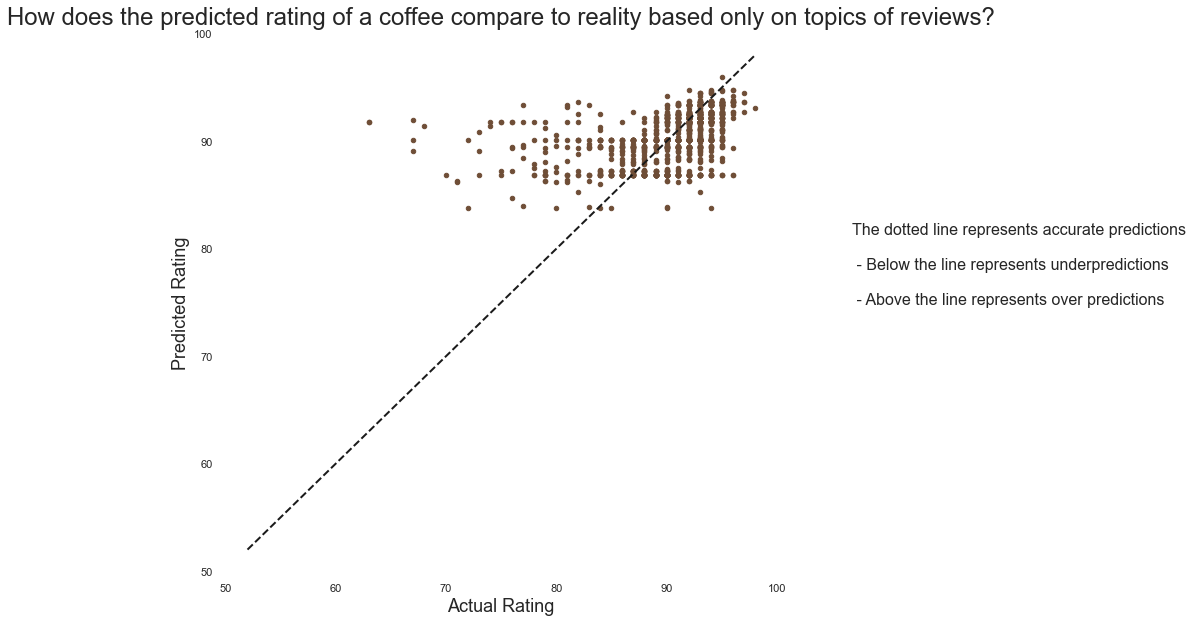

In [136]:
y = one_hot.rating
sns.set(rc={'figure.figsize':(10, 10)})
fig, ax = plt.subplots()
ax.scatter(y_, word_lasso_pred, s=20,color='#6f4e37')
ax.set_facecolor('white')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Actual Rating',fontsize=18)
ax.set_ylabel('Predicted Rating',fontsize=18)
ax.set_title('How does the predicted rating of a coffee compare to reality based only on topics of reviews?',fontsize=24)
txt = 'The dotted line represents accurate predictions' + '\n \n'+' - Below the line represents underpredictions' + '\n\n'+ ' - Above the line represents over predictions'
text = fig.text(1,.5,txt,fontsize=16)
# fig.savefig('OneDrive\Desktop\Metis\Projects\Project 2\wridge_actualvspredicted',kind='png')
plt.show()

In [143]:
# Can I look at which topics appear in the errors most often and surmise they are hurting predictions? Not good topics?
word_errors = pd.concat([pd.DataFrame(y_),pd.DataFrame(X_)],axis=1)
word_errors['preds'] = lasso_words.predict(word_errors.drop(columns='rating'))
word_errors['error'] = np.absolute(word_errors.rating-word_errors.preds)
word_errors.sort_values(by='error',ascending=False).head(100).mean()

rating           79.580000
Two Topic_0       0.240000
Two Topic_1       0.760000
Three Topic_0     0.250000
Three Topic_1     0.540000
Three Topic_2     0.210000
Four Topic_0      0.170000
Four Topic_1      0.470000
Four Topic_2      0.180000
Four Topic_3      0.180000
Five Topic_0      0.060000
Five Topic_1      0.390000
Five Topic_2      0.160000
Five Topic_3      0.220000
Five Topic_4      0.170000
Six Topic_0       0.030000
Six Topic_1       0.360000
Six Topic_2       0.100000
Six Topic_3       0.170000
Six Topic_4       0.190000
Six Topic_5       0.150000
Seven Topic_0     0.020000
Seven Topic_1     0.350000
Seven Topic_2     0.100000
Seven Topic_3     0.090000
Seven Topic_4     0.160000
Seven Topic_5     0.150000
Seven Topic_6     0.130000
Eight Topic_0     0.000000
Eight Topic_1     0.140000
Eight Topic_2     0.040000
Eight Topic_3     0.070000
Eight Topic_4     0.140000
Eight Topic_5     0.080000
Eight Topic_6     0.030000
Eight Topic_7     0.500000
Nine Topic_0      0.000000
N

In [128]:
# kf = KFold(n_splits=5, shuffle=True, random_state = 42)
# cv_lm_poly_r2s = []
# train_X, train_y = np.array(_X), np.array(_y)
# for train_ind, val_ind in kf.split(train_X, train_y):    
    
#     tr_X, tr_y = train_X[train_ind], train_y[train_ind]
#     X_val, y_val = train_X[val_ind], train_y[val_ind] 
    
#     #poly with degree 2
#     poly = PolynomialFeatures(degree=2,interaction_only=True)

#     X_train_poly = poly.fit_transform(tr_X)
#     X_val_poly = poly.transform(X_val)

#     lm_poly = LinearRegression()
    
#     lm_poly.fit(X_train_poly, tr_y)
#     cv_lm_poly_r2s.append(round(lm_poly.score(X_val_poly, y_val), 3))
    
# print('Poly scores: ', cv_lm_poly_r2s, '\n')

# print(f'Poly mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}')

# alphavec = 10**np.linspace(-2,2,200)
# std_poly = StandardScaler()
# std_poly.fit(X_train_poly)
# X_polylasso = std_poly.transform(X_train_poly)

# lasso_poly =  LassoCV(alphas = alphavec, cv = 5)
# lasso_poly.fit(X_train_poly,tr_y)
# list(zip(poly.get_feature_names(_X.columns), lasso_poly.coef_))

In [363]:
with open('lm_aroma.pickle', 'wb') as to_write:
    pickle.dump(lm_aroma, to_write)
with open('lm_acidity.pickle', 'wb') as to_write:
    pickle.dump(lm_acidity, to_write)
with open('lm_aftertaste.pickle', 'wb') as to_write:
    pickle.dump(lm_aftertaste, to_write)
with open('lm_flavor.pickle', 'wb') as to_write:
    pickle.dump(lm_flavor, to_write)
with open('lm_body.pickle', 'wb') as to_write:
    pickle.dump(lm_body, to_write)

with open('words_to_score_RF.pickle', 'wb') as to_write:
    pickle.dump(rfr, to_write)
with open('num_to_score_RF.pickle', 'wb') as to_write:
    pickle.dump(rf_numerical, to_write)